<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [1]:
!nvidia-smi

Wed Sep 14 15:48:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [2]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [3]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np
from shutil import move
from os.path import join
import os
from google.colab import files
from shutil import copyfile

Download the dataset from a remote repository.

In [5]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

100% 2.17G/2.18G [00:31<00:00, 77.3MB/s]
100% 2.18G/2.18G [00:31<00:00, 75.0MB/s]


Create Directories for Train, Validation and Test sets

In [6]:
os.makedirs(os.path.join(os.environ["data_source"], 'train/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'train/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/faces'))

tmp_comics_dir = './Face_Comics_data/comics'
tmp_faces_dir = './Face_Comics_data/faces'
comics_test_dir = './Face_Comics_data/test/comics'
faces_test_dir = './Face_Comics_data/test/faces'
comics_validation_dir = './Face_Comics_data/validation/comics'
faces_validation_dir = './Face_Comics_data/validation/faces'
comics_train_dir = './Face_Comics_data/train/comics'
faces_train_dir = './Face_Comics_data/train/faces'
train_dir = './Face_Comics_data/train'
validation_dir = './Face_Comics_data/validation'
test_dir = './Face_Comics_data/test'

Define global variables

In [7]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
EPOCHS = 50
EXPERIMENT_SIZE = 10000
CONV2D_layers_number = 3

Split the original dataset into Train, Validation and Test sets.

In [8]:
#TEST - TRAINING SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_train_dir, i))
      c += 1
    else:
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_test_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      try:
        move(os.path.join(tmp_faces_dir, i), os.path.join(faces_train_dir, i))
        c += 1
      except:
        c+= 1
        next
    else:
      move(os.path.join(tmp_faces_dir, i), os.path.join(faces_test_dir, i))
      c += 1

TRAIN_SIZE = len(os.listdir(comics_train_dir))

#TRAINING - VALIDATION SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/train/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/train/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(comics_train_dir, i), os.path.join(comics_validation_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(faces_train_dir, i), os.path.join(faces_validation_dir, i))
      c += 1

print('Total training images :', len(os.listdir(comics_train_dir)) + len(os.listdir(faces_train_dir)))
print('Total validation images :', len(os.listdir(comics_validation_dir)) + len(os.listdir(faces_validation_dir)))
print('Total test images :', len(os.listdir(comics_test_dir)) + len(os.listdir(faces_test_dir)))

Total training images : 9800
Total validation images : 4200
Total test images : 6000


Define data augmentation functions to be implemented in the analysis.

In [9]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

Define the CNN model with dynamic structure based on external Hyperparameter. 

In [10]:
for i in range(CONV2D_layers_number):
  Dynamic_Variable_Name = "model_"
  Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)
  globals()[Dynamic_Variable_Name] = Sequential()
  globals()[Dynamic_Variable_Name].add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))
    
  for l in range(CONV2D_layers_number):
          globals()[Dynamic_Variable_Name].add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
          globals()[Dynamic_Variable_Name].add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))


  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Flatten())


  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

  globals()[Dynamic_Variable_Name].compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])


Create a Strategy scope, and put the compiled model inside it. Run the distributed Training, Validation and Test analysis for each Model.

In [11]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


Define Training, Validation and test datasets.

In [12]:
def get_dataset():
    BUFFER_SIZE = 10000
    IMG_SIZE = (350, 350)
    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


    tf.random.set_seed(123456)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )

def AIC(n_examples, mse, n_model_parameters):
  AIC_SCORE = (n_examples * np.log(mse) ) + (2*n_model_parameters)
  return AIC_SCORE


Example of data augmentation

Found 9800 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.
Found 6000 files belonging to 2 classes.


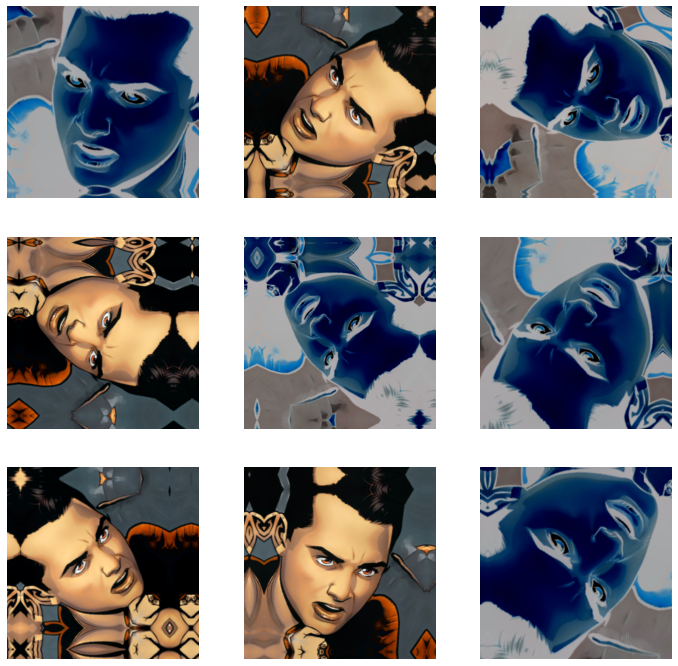

In [13]:
train_dataset, validation_dataset, test_dataset = get_dataset()

data_augmentation = tf.keras.Sequential([
	  layers.RandomFlip("horizontal_and_vertical"),
	  layers.RandomRotation(0.5),
    layers.RandomContrast(0.1, seed=None),
    RandomInvert(),
    layers.RandomZoom(height_factor=(-0.2, +0.3)),
    layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05))
    ])


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Create a Strategy scope, and put the compiled model inside it. Run the distributed Training, Validation and Test analysis for each Model.

****************************** Model n.1 ******************************
Epoch 1/50
154/154 [==============================] - 86s 444ms/step - loss: 0.4435 - accuracy: 0.7800 - mse: 0.1454 - val_loss: 0.1722 - val_accuracy: 0.9348 - val_mse: 0.0487
Epoch 2/50
154/154 [==============================] - 69s 433ms/step - loss: 0.1412 - accuracy: 0.9535 - mse: 0.0363 - val_loss: 0.1963 - val_accuracy: 0.9410 - val_mse: 0.0473
Epoch 3/50
154/154 [==============================] - 67s 424ms/step - loss: 0.1266 - accuracy: 0.9607 - mse: 0.0319 - val_loss: 0.0576 - val_accuracy: 0.9807 - val_mse: 0.0148
Epoch 4/50
154/154 [==============================] - 67s 424ms/step - loss: 0.0404 - accuracy: 0.9885 - mse: 0.0089 - val_loss: 0.0267 - val_accuracy: 0.9940 - val_mse: 0.0049
Epoch 5/50
154/154 [==============================] - 68s 426ms/step - loss: 0.1409 - accuracy: 0.9489 - mse: 0.0388 - val_loss: 0.1262 - val_accuracy: 0.9571 - val_mse: 0.0332
Epoch 6/50
154/154 [=======================

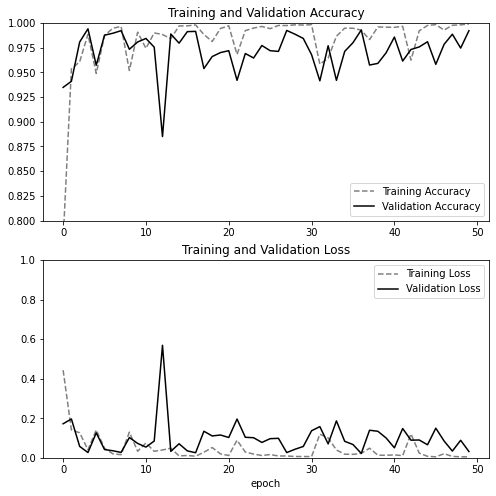

****************************** Test Evaluate ******************************
94/94 [==============================] - 31s 308ms/step - loss: 0.0294 - accuracy: 0.9908 - mse: 0.0070
****************************** Model n.2 ******************************
Epoch 1/50
154/154 [==============================] - 72s 428ms/step - loss: 0.4334 - accuracy: 0.7987 - mse: 0.1396 - val_loss: 0.1903 - val_accuracy: 0.9286 - val_mse: 0.0540
Epoch 2/50
154/154 [==============================] - 67s 422ms/step - loss: 0.1310 - accuracy: 0.9569 - mse: 0.0340 - val_loss: 0.1478 - val_accuracy: 0.9538 - val_mse: 0.0348
Epoch 3/50
154/154 [==============================] - 66s 417ms/step - loss: 0.0963 - accuracy: 0.9676 - mse: 0.0244 - val_loss: 0.0888 - val_accuracy: 0.9717 - val_mse: 0.0229
Epoch 4/50
154/154 [==============================] - 67s 419ms/step - loss: 0.0420 - accuracy: 0.9899 - mse: 0.0088 - val_loss: 0.0413 - val_accuracy: 0.9883 - val_mse: 0.0090
Epoch 5/50
154/154 [====================

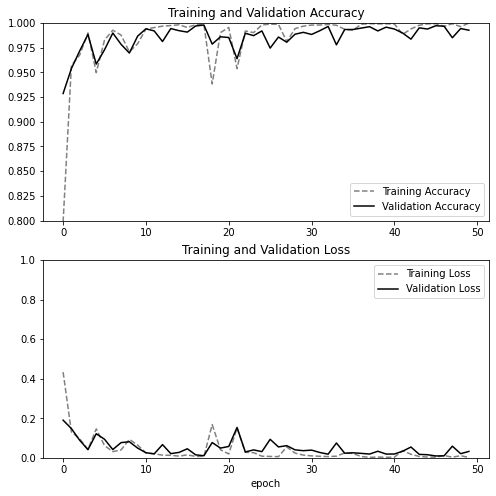

****************************** Test Evaluate ******************************
94/94 [==============================] - 29s 288ms/step - loss: 0.0224 - accuracy: 0.9935 - mse: 0.0051
****************************** Model n.3 ******************************
Epoch 1/50
154/154 [==============================] - 73s 435ms/step - loss: 0.4520 - accuracy: 0.7869 - mse: 0.1469 - val_loss: 0.1241 - val_accuracy: 0.9607 - val_mse: 0.0323
Epoch 2/50
154/154 [==============================] - 69s 437ms/step - loss: 0.1134 - accuracy: 0.9669 - mse: 0.0279 - val_loss: 0.0526 - val_accuracy: 0.9848 - val_mse: 0.0123
Epoch 3/50
154/154 [==============================] - 72s 457ms/step - loss: 0.0364 - accuracy: 0.9907 - mse: 0.0082 - val_loss: 0.0268 - val_accuracy: 0.9931 - val_mse: 0.0054
Epoch 4/50
154/154 [==============================] - 71s 447ms/step - loss: 0.1933 - accuracy: 0.9452 - mse: 0.0470 - val_loss: 0.0762 - val_accuracy: 0.9767 - val_mse: 0.0184
Epoch 5/50
154/154 [====================

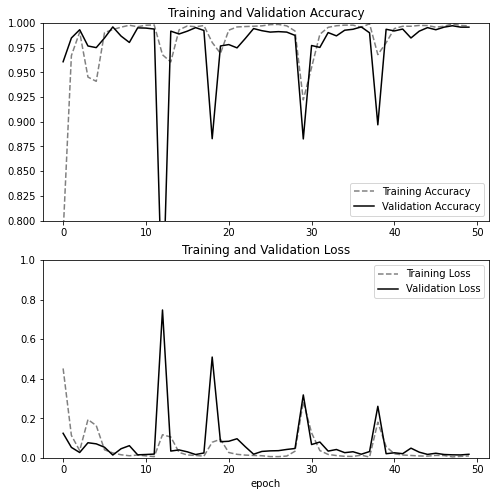

****************************** Test Evaluate ******************************
94/94 [==============================] - 30s 298ms/step - loss: 0.0118 - accuracy: 0.9958 - mse: 0.0031


In [14]:
#Compute number of examples
Example_number = 9800

AIC_list = []
MSE_list = []
Models_parameters_n_list = []
Test_mse = []

for i in range(CONV2D_layers_number):
  with strategy.scope():
    print(f'****************************** Model n.{i+1} ******************************')
    Dynamic_Variable_Name = "model_"
    Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)
    model_fit = globals()[Dynamic_Variable_Name].fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)
    model_fit
    globals()[Dynamic_Variable_Name].summary()

    #Retrieve MSE values for each epoch
    Model_MSE = model_fit.history['mse']
    MSE_list += model_fit.history['mse']

    #Retrieve Parameters numbers for each model
    stringlist = []
    globals()[Dynamic_Variable_Name].summary(line_length=70, print_fn=lambda x: stringlist.append(x))

    substring = 'Trainable params'

    c = 0
    for n in stringlist:
        if substring not in n:
          c += 1
        else:
          break

    substring = stringlist[c]  
    Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
    Models_parameters_n_list += [Model_parameters_n]

    #Aikaike Information Creterion (AIC) Computation
    for mse_score in Model_MSE:
      AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
      AIC_list += AIC_SCORE

    #Show training and validation graphs
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss_ = model_fit.history['loss']
    val_loss_ = model_fit.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
    plt.plot(val_acc, label='Validation Accuracy', color = 'black')
    plt.ylim([0.8, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
    plt.plot(val_loss_, label='Validation Loss', color = 'black')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    print('****************************** Test Evaluate ******************************')
    model_evaluate = globals()[Dynamic_Variable_Name].evaluate(test_dataset)  
    Test_mse += [model_evaluate[2]]


Show Histoical validation AIC scores and Moving Average AIC scores graphs

Text(0.5, 1.0, 'Validation Average AIC')

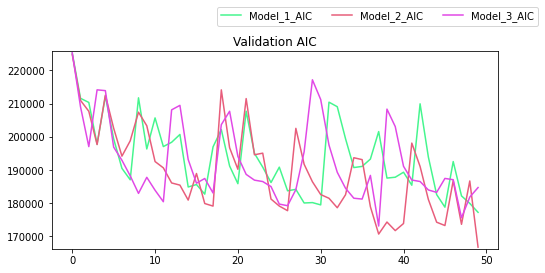

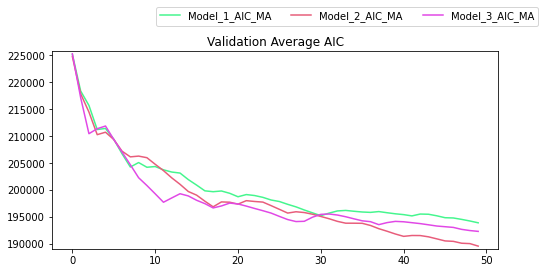

In [15]:
lim = []
for i in range(CONV2D_layers_number):
    Dynamic_Variable_Name = 'Model_'+str(i+1)+'_AIC'
    Dynamic_Variable_Name_2 = 'Model_'+str(i+1)+'_AIC_MA'
    Dynamic_Variable_Name_3 = 'avg_score_Model_'+str(i+1)
    globals()[Dynamic_Variable_Name] = AIC_list[(i*EPOCHS):((i+1)*EPOCHS)]
    globals()[Dynamic_Variable_Name_2] = globals()[Dynamic_Variable_Name]
    globals()[Dynamic_Variable_Name_3] = [] 
    for n in range(len(globals()[Dynamic_Variable_Name])):
      globals()[Dynamic_Variable_Name_3] += [sum(globals()[Dynamic_Variable_Name][:(n+1)])/(n+1)]
    globals()[Dynamic_Variable_Name_2] = globals()[Dynamic_Variable_Name_3]
    lim += globals()[Dynamic_Variable_Name_3]

Min = min(lim)
Max = max(lim)

r_list = []
b_list = []
g_list = []
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
for i in range(CONV2D_layers_number):
    r = random.random()
    b = random.random()
    g = random.random()
    r_list += [r]
    b_list += [b]
    g_list += [g]
    color = (r, g, b)
    Dynamic_Variable_Name = "Model_"
    Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)+'_AIC'
    plt.plot(globals()[Dynamic_Variable_Name], label=str(Dynamic_Variable_Name), color = color)
plt.ylim([min(AIC_list)-500, max(AIC_list)+500])
plt.legend(bbox_to_anchor =(1.1, 1.25), ncol = 4)
plt.title('Validation AIC')


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
for i in range(CONV2D_layers_number):
    r = r_list[i]
    b = b_list[i]
    g = g_list[i]
    color = (r, g, b)
    Dynamic_Variable_Name = "Model_"
    Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)+'_AIC_MA'
    plt.plot(globals()[Dynamic_Variable_Name], label=str(Dynamic_Variable_Name), color = color)
plt.ylim([(Min-500), (Max+500)])
plt.legend(bbox_to_anchor =(1.1, 1.25), ncol = 4)
plt.title('Validation Average AIC')


Automatic Model Selection based on Test MSE scores

In [16]:
d = {}
for i in range(CONV2D_layers_number):
  Dynamic_Variable_Name = "Model_"
  Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)
  d.update({str(Dynamic_Variable_Name) : Test_mse[i]})

print('***************************************** Test MSE Results *****************************************')
print(d)
print('****************************************************************************************************')
best_model = min(d, key=d.get)
print(f'The Best Model is: {best_model}')

***************************************** Test MSE Results *****************************************
{'Model_1': 0.006983501370996237, 'Model_2': 0.005122559145092964, 'Model_3': 0.003084773663431406}
****************************************************************************************************
The Best Model is: Model_3
